In [35]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [5]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train_df = train_df.drop(columns = ['keyword', 'location'])
test_df = test_df.drop(columns = ['keyword', 'location'])

In [7]:
#dropping ID due to it having distinct values
train_df = train_df.drop(columns = ['id'])
test_id = test_df['id']
target = train_df['target']

In [8]:
X_train = train_df['text']
Y_train = train_df['target']
X_test = test_df['text']



In [9]:
#finding the maximum length of the input sentence
def find_longest_length(tweets):

    max_length = 0
    for i, text in enumerate(tweets):
        corpus = [
            word for word in text.split()
        ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length

In [10]:
max_len = find_longest_length(X_train)
# Use these many top words from the dataset. If -1, use all words.
NUM_WORDS = -1 # Vocabulary size.
# Batch size.
BATCH_SIZE = 512
VALID_SPLIT = 0.20

In [11]:
from collections import Counter
def find_word_frequency(tweets, most_common=None):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.
    :param tweets: A pandas data series.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.
    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for i, text in enumerate(tweets):
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all if n is `None`.
    return word_frequency

In [12]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.
    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.
    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """
    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

In [13]:
word_frequency = find_word_frequency(X_train)
word_frequency_test = find_word_frequency(X_test)
vocab_size = len(word_frequency)
print(f"the total number of unique words are {vocab_size}")
int_mapping = word2int(word_frequency, num_words=NUM_WORDS)

the total number of unique words are 31924


In [14]:
import string
def standardize_text(input_text):
        # Convert everything to lower case.
        text = input_text.lower()
        # Remove punctuation marks using `string` module.
        # According to `string`, the following will be removed,
        # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        text = ''.join([
            character for character in text \
                if character not in string.punctuation
        ])
        return text

In [15]:
X_train_standardize = X_train.copy()
X_test_standardize = X_test.copy()

In [16]:
def return_int_vector(self, int_mapping, tweet):
        """
        Assign an integer to each word and return the integers in a list.
        """
        text = self.standardize_text(tweet)
        corpus = [
            word for word in text.split()
        ] 
        # Each word is replaced by a specific integer.
        int_vector = [
            int_mapping[word] for word in text.split() \
            if word in int_mapping
        ]
        return int_vector

In [17]:
for i in range(0,len(X_train)):
    X_train_standardize[i] = standardize_text(X_train[i])
for k in range(0, len(X_test)):
    X_test_standardize[k] = standardize_text(X_test[k])

In [18]:

def return_int_vector(int_mapping, tweet):
    """
    Assign an integer to each word and return the integers in a list.
    """
    corpus = [word for word in tweet.split()] 
    # Each word is replaced by a specific integer.
    int_vector = [int_mapping[word] for word in tweet.split() if word in int_mapping]
    return int_vector

In [19]:
def pad_features(int_vector, max_len):
    """
    Return features of `int_vector`, where each vector is padded 
    with 0's or truncated to the input seq_length. Return as Numpy 
    array.
    """
    features = np.zeros((1, max_len), dtype = int)
    if len(int_vector) <= max_len:
        zeros = list(np.zeros(max_len - len(int_vector)))
        new = zeros + int_vector
    else:
        new = int_vector[: max_len]
    features = np.array(new)
    return features

In [20]:
int_vector = list()
dataset = list()
for words in X_train_standardize:
    int_vector.append(return_int_vector(int_mapping, words))
for seq in int_vector:
    dataset.append(pad_features(seq, max_len))
    
int_vector_test = list()
dataset_test = list()
for words in X_test_standardize:
    int_vector_test.append(return_int_vector(int_mapping, words))
for seq in int_vector_test:
    dataset_test.append(pad_features(seq, max_len))

In [21]:
dict_ = { 'text' : torch.tensor(dataset, dtype = torch.int32),
        'label': torch.tensor(Y_train)}
dict_test = { 'text' : torch.tensor(dataset_test, dtype = torch.int32)}
dict_['text'][0]


/tmp/ipykernel_42/2385306111.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  dict_ = { 'text' : torch.tensor(dataset, dtype = torch.int32),


tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          119,    24,     1,   997,     5,    25,   950,   124, 15685,   192,
           50], dtype=torch.int32)

In [22]:
data_size = len(dict_['text'])
data_size_test = len(dict_test['text'])
range(data_size_test)

range(0, 3263)

In [23]:
from torch.utils.data import Subset
indices = torch.randperm(len(dataset)).tolist()
train_size = int((1-VALID_SPLIT) * data_size)
X_dataset_train = [dict_['text'][i] for i in indices[:train_size]]
X_dataset_train = torch.stack(X_dataset_train)
Y_dataset_train =[dict_['label'][i] for i in indices[:train_size]]
Y_dataset_train = torch.stack(Y_dataset_train)
X_dataset_valid = [dict_['text'][i] for i in indices[train_size:]]
X_dataset_valid = torch.stack(X_dataset_valid)
Y_dataset_valid = [dict_['label'][i] for i in indices[train_size:]]
Y_dataset_valid = torch.stack(Y_dataset_valid)
X_dataset_test = [dict_test['text'][i] for i in range(data_size_test)]
X_dataset_test = torch.stack(X_dataset_test)

In [24]:
print(f"Number of training samples: {(X_dataset_train.shape[0])}")
print(f"Number of validation samples: {(X_dataset_valid.shape[0])}")
print(f"Number of test samples: {(X_dataset_test.shape[0])}")


Number of training samples: 6090
Number of validation samples: 1523
Number of test samples: 3263


In [25]:
Y_dataset_train = Y_dataset_train.to(dtype = torch.float32)
Y_dataset_valid = Y_dataset_valid.to(dtype = torch.float32)

In [42]:
embedding_dim = 64
hidden_dim = 64
output_dim = 1

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out,_ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]
        output = self.sigmoid(self.fc(lstm_out))
        return output


In [43]:
model = LSTMModel()
print(model)

LSTMModel(
  (embedding): Embedding(31924, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [44]:
import torch.optim as optim
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
running_train = []
running_val = []
epochs = 5
batch_size = 100
for epoch in range(epochs):
    for i in range(0, len(X_dataset_train), batch_size):
        Xbatch = X_dataset_train[i:i+batch_size]
        Ybatch = Y_dataset_train[i:i+batch_size]
        Y_pred = model(Xbatch)
        loss = loss_fn(Y_pred.squeeze(), Ybatch)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        acc = (Y_pred.round() == Ybatch).float().mean()
        
  
    print(f'Finished epoch {epoch}, latest loss {loss}')
    running_train.append(loss)
    
    
    
    
    model.eval()
    with torch.no_grad():
        val_output = model(X_dataset_valid)
        loss = loss_fn(val_output.squeeze(), Y_dataset_valid)
        print(f'validation loss: {loss}')
        running_val.append(loss)
    

Finished epoch 0, latest loss 0.6618074774742126
validation loss: 0.6676716804504395
Finished epoch 1, latest loss 0.5889215469360352
validation loss: 0.6032891273498535
Finished epoch 2, latest loss 0.5012142658233643
validation loss: 0.558273196220398
Finished epoch 3, latest loss 0.4347743093967438
validation loss: 0.5285345315933228
Finished epoch 4, latest loss 0.37863391637802124
validation loss: 0.5170514583587646


Text(0, 0.5, 'Loss')

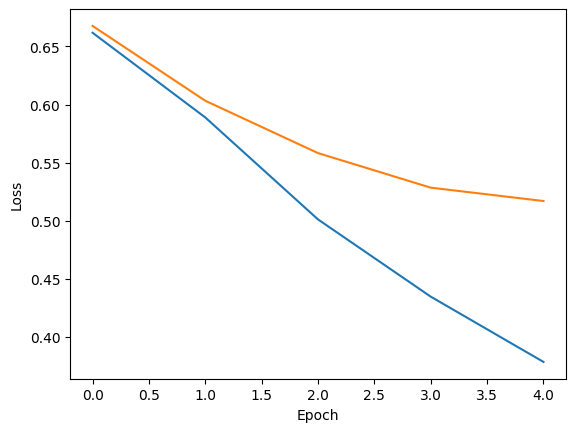

In [48]:
# running_train = [tensor.item() for tensor in running_train]
# running_val = [tensor.item() for tensor in running_val]
plt.plot(running_train)
plt.plot(running_val)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [49]:
#making test predictions
Y_test = model(X_dataset_test).round()
Y_test = Y_test.to(dtype = torch.int32)
Y_test = Y_test.detach().numpy()


In [50]:
test_df['target'] = Y_test

In [52]:
test_df[['id', 'target']].to_csv('tweet_disaster_pred.csv', index = False)